https://www.kaggle.com/code/imsparsh/food-classifier-mobilenetv2-resnet50-vgg16

In [1]:
# importing libraries
import os, time
os.environ['PYTHONHASHSEED']=str(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# %load_ext tensorboard
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('seaborn-deep')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (12, 8)

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 400)
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
seed = 12

<ipython-input-1-6d6a36f45a00>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-deep')


In [2]:
import tensorflow as tf
from tensorflow import keras as k
print(tf.__version__)
from keras import backend as K
import os, shutil, re, string
import matplotlib.pyplot as plt
import spacy
seed=100

2.15.0


In [3]:
from skimage.transform import resize
from skimage import img_as_ubyte
from imageio import imread
import datetime

def set_seed():
    global seed
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

In [4]:
import os
import zipfile

# Kaggle API 키를 설정합니다.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Kaggle 데이터셋을 다운로드합니다.
!kaggle datasets download -d kmader/food41

# 다운로드한 데이터셋을 압축 해제합니다.
with zipfile.ZipFile("food41.zip", 'r') as zip_ref:
    zip_ref.extractall("food41")

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/kmader/food41
License(s): copyright-authors
100% 5.30G/5.30G [02:58<00:00, 34.7MB/s]
100% 5.30G/5.30G [02:58<00:00, 31.9MB/s]


In [5]:
import json
folder_main = 'food41'
folder_images = os.path.join(folder_main, 'images')
trainjson_fp = folder_main+'/meta/meta/train.json'
testjson_fp = folder_main+'/meta/meta/test.json'
with open(trainjson_fp, 'r') as f:
    trainjson = json.load(f)
with open(testjson_fp, 'r') as f:
    testjson = json.load(f)
labels = list(trainjson.keys())
labels[:5]

['churros', 'hot_and_sour_soup', 'samosa', 'sashimi', 'pork_chop']

In [6]:
labels

['churros',
 'hot_and_sour_soup',
 'samosa',
 'sashimi',
 'pork_chop',
 'spring_rolls',
 'panna_cotta',
 'beef_tartare',
 'greek_salad',
 'foie_gras',
 'tacos',
 'pad_thai',
 'poutine',
 'ramen',
 'pulled_pork_sandwich',
 'bibimbap',
 'beignets',
 'apple_pie',
 'crab_cakes',
 'risotto',
 'paella',
 'steak',
 'baby_back_ribs',
 'miso_soup',
 'frozen_yogurt',
 'club_sandwich',
 'carrot_cake',
 'falafel',
 'bread_pudding',
 'chicken_wings',
 'gnocchi',
 'caprese_salad',
 'creme_brulee',
 'escargots',
 'chocolate_cake',
 'tiramisu',
 'spaghetti_bolognese',
 'mussels',
 'scallops',
 'baklava',
 'edamame',
 'macaroni_and_cheese',
 'pancakes',
 'garlic_bread',
 'beet_salad',
 'onion_rings',
 'red_velvet_cake',
 'grilled_salmon',
 'chicken_curry',
 'deviled_eggs',
 'caesar_salad',
 'hummus',
 'fish_and_chips',
 'lasagna',
 'peking_duck',
 'guacamole',
 'strawberry_shortcake',
 'clam_chowder',
 'croque_madame',
 'french_onion_soup',
 'beef_carpaccio',
 'fried_rice',
 'donuts',
 'gyoza',
 'ravio

In [7]:
# helper function

def readImg(img):
    global folder_images
    return imread(os.path.join(folder_images, img+'.jpg'))

def showImg(img):
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.show()

Total number of samples for train 75750
Some samples are ['foie_gras/3381348', 'fried_rice/695097', 'beef_tartare/2955997', 'chocolate_cake/2120098', 'grilled_cheese_sandwich/866030']
Sample Image Shape (512, 512, 3)


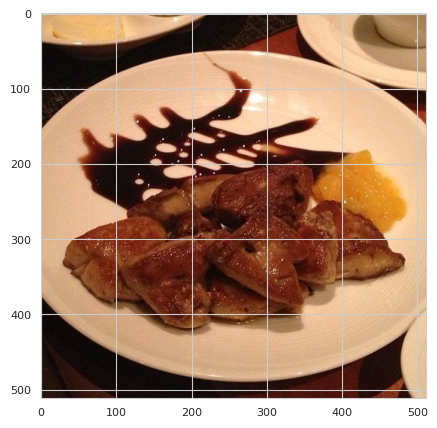

In [8]:
# create training data
set_seed()
train_samples = list(np.random.permutation(list(pd.core.common.flatten(trainjson.values()))))
print("Total number of samples for train",len(train_samples))
print("Some samples are",train_samples[:5])
sample_img = readImg(train_samples[0])
print("Sample Image Shape",sample_img.shape)
showImg(sample_img)

In [9]:
list(pd.core.common.flatten(trainjson.values()))

['churros/1004234',
 'churros/1013460',
 'churros/1016791',
 'churros/102100',
 'churros/1025494',
 'churros/1029245',
 'churros/1029669',
 'churros/1031729',
 'churros/1037793',
 'churros/1062354',
 'churros/1064040',
 'churros/1066964',
 'churros/1067707',
 'churros/1071888',
 'churros/107235',
 'churros/1075103',
 'churros/1075574',
 'churros/1076994',
 'churros/1078896',
 'churros/1081831',
 'churros/1086460',
 'churros/1086967',
 'churros/1094673',
 'churros/1096129',
 'churros/1096756',
 'churros/1097647',
 'churros/1103507',
 'churros/1109507',
 'churros/1122259',
 'churros/1130092',
 'churros/1135011',
 'churros/1141049',
 'churros/1142539',
 'churros/1143913',
 'churros/115417',
 'churros/1154541',
 'churros/1155176',
 'churros/1160320',
 'churros/1166531',
 'churros/1168265',
 'churros/1168743',
 'churros/1170523',
 'churros/1171026',
 'churros/1176177',
 'churros/1176714',
 'churros/1179015',
 'churros/1189105',
 'churros/1200326',
 'churros/1202914',
 'churros/1206968',
 'c

Total number of samples for test 25250
Some samples are ['pancakes/2500916', 'hamburger/873705', 'chocolate_cake/723737', 'peking_duck/1439069', 'guacamole/803906']
Sample Image Shape (384, 512, 3)


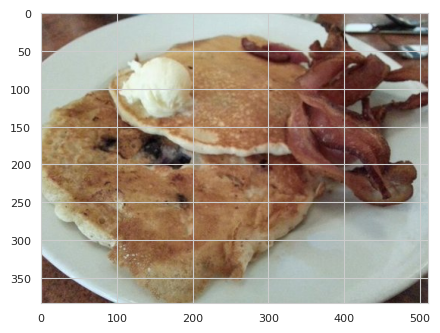

In [10]:
# create testing data
set_seed()
test_samples = list(np.random.permutation(list(pd.core.common.flatten(testjson.values()))))
print("Total number of samples for test",len(test_samples))
print("Some samples are",test_samples[:5])
sample_img = readImg(test_samples[0])
print("Sample Image Shape",sample_img.shape)
showImg(sample_img)

In [11]:
train_sample_one = ['lasagna/3787908', 'bread_pudding/1375816', 'steak/1340977']
train_samples = [x for x in train_samples if x not in train_sample_one]
print("Remaining samples for train are",len(train_samples))

Remaining samples for train are 75747


Total number of samples for train 5050
Some samples are ['crab_cakes/1185208', 'pork_chop/1039231', 'caesar_salad/1053979', 'peking_duck/1120554', 'greek_salad/1040156']
Sample Image Shape (288, 512, 3)


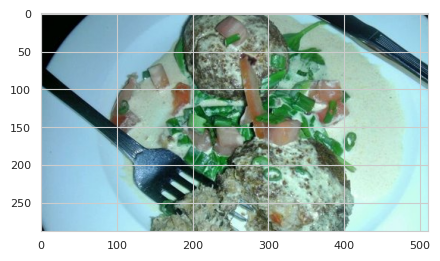

In [12]:
# create training data
train_samples_subset_list = []
for x in trainjson.keys():
    train_samples_subset_list.extend(trainjson[x][:50])
set_seed()
train_samples_subset = list(np.random.permutation(train_samples_subset_list))
print("Total number of samples for train",len(train_samples_subset))
print("Some samples are",train_samples_subset[:5])
sample_img = readImg(train_samples_subset[0])
print("Sample Image Shape",sample_img.shape)
showImg(sample_img)

In [13]:
# remove single channel image
train_sample_one = ['lasagna/3787908', 'bread_pudding/1375816', 'steak/1340977']
train_samples_subset = [x for x in train_samples_subset if x not in train_sample_one]
print("Remaining samples for train are",len(train_samples_subset))

Remaining samples for train are 5050


Total number of samples for test 2020
Some samples are ['waffles/1231392', 'pho/1151446', 'hot_dog/1123406', 'spaghetti_carbonara/1180742', 'creme_brulee/1127473']
Sample Image Shape (384, 512, 3)


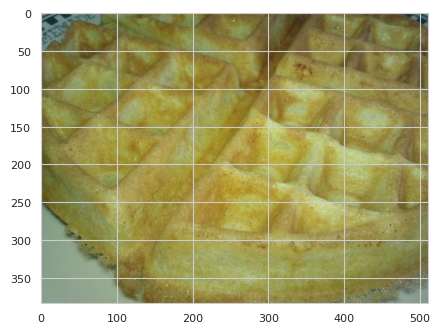

In [14]:
# create testing data
test_samples_subset_list = []
for x in testjson.keys():
    test_samples_subset_list.extend(testjson[x][:20])
set_seed()
test_samples_subset = list(np.random.permutation(test_samples_subset_list))
print("Total number of samples for test",len(test_samples_subset))
print("Some samples are",test_samples_subset[:5])
sample_img = readImg(test_samples_subset[0])
print("Sample Image Shape",sample_img.shape)
showImg(sample_img)

In [15]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(labels):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'churros': 0, 'hot_and_sour_soup': 1, 'samosa': 2, 'sashimi': 3, 'pork_chop': 4, 'spring_rolls': 5, 'panna_cotta': 6, 'beef_tartare': 7, 'greek_salad': 8, 'foie_gras': 9, 'tacos': 10, 'pad_thai': 11, 'poutine': 12, 'ramen': 13, 'pulled_pork_sandwich': 14, 'bibimbap': 15, 'beignets': 16, 'apple_pie': 17, 'crab_cakes': 18, 'risotto': 19, 'paella': 20, 'steak': 21, 'baby_back_ribs': 22, 'miso_soup': 23, 'frozen_yogurt': 24, 'club_sandwich': 25, 'carrot_cake': 26, 'falafel': 27, 'bread_pudding': 28, 'chicken_wings': 29, 'gnocchi': 30, 'caprese_salad': 31, 'creme_brulee': 32, 'escargots': 33, 'chocolate_cake': 34, 'tiramisu': 35, 'spaghetti_bolognese': 36, 'mussels': 37, 'scallops': 38, 'baklava': 39, 'edamame': 40, 'macaroni_and_cheese': 41, 'pancakes': 42, 'garlic_bread': 43, 'beet_salad': 44, 'onion_rings': 45, 'red_velvet_cake': 46, 'grilled_salmon': 47, 'chicken_curry': 48, 'deviled_eggs': 49, 'caesar_salad': 50, 'hummus': 51, 'fish_and_chips': 52, 'lasagna': 53, 'peking_duck': 54, 'g

In [16]:
# hyper-parameters

img_tensor = [128, 128, 3]

In [17]:
def cropResize(image, y, z):
    return img_as_ubyte(resize(image, (y,z)))

def normalizeImage(image):
    # applying normalization
    return image/255.0

def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

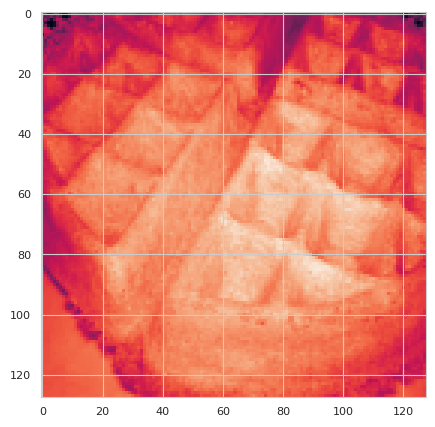

In [18]:
# display sample preprocessed image
sample_img_r = sample_img[:, :, 0]
sample_img_r_pre = preprocessImage(sample_img_r, 128, 128)
showImg(sample_img_r_pre)

In [ ]:
# flip
def flipImage(img):
    return np.flip(img)

In [ ]:
# display sample preprocessed image
sample_img_r = sample_img[:, :, 0]
sample_img_r_pre = preprocessImage(flipImage(sample_img_r), 128, 128)
showImg(sample_img_r_pre)

In [ ]:
def getBatchData(t, batch, batch_size, flip):
    global img_tensor, labels
    [h, w, c] = [img_tensor[0], img_tensor[1], img_tensor[2]]
    batch_data = np.zeros((batch_size,h,w,c)) # generating null image representations
    batch_labels = np.zeros((batch_size, len(labels))) # batch_labels is the one hot representation of output
    if flip:
        batch_data_flip = np.zeros((batch_size,h,w,c))
        batch_labels_flip = np.zeros((batch_size, len(labels)))
    # batch_labels = []
    for idx in range(batch_size): # iterating over the batch_size
        imgPath = t[idx + (batch*batch_size)]
        imgLabel = imgPath.strip().split('/')[0]
        image = readImg(imgPath)

        # separate preprocessImage function is defined for cropping, resizing and normalizing images
        batch_data[idx,:,:,0] = preprocessImage(image[:, :, 0], h, w)
        batch_data[idx,:,:,1] = preprocessImage(image[:, :, 1], h, w)
        batch_data[idx,:,:,2] = preprocessImage(image[:, :, 2], h, w)

        batch_labels[idx, label_index[imgLabel]] = 1

        if flip:
            batch_data_flip[idx,:,:,0] = preprocessImage(flipImage(image[:, :, 0]), h, w)
            batch_data_flip[idx,:,:,1] = preprocessImage(flipImage(image[:, :, 1]), h, w)
            batch_data_flip[idx,:,:,2] = preprocessImage(flipImage(image[:, :, 2]), h, w)

            batch_labels_flip[idx, label_index[imgLabel]] = 1
    if flip:
        batch_data = np.concatenate((batch_data, batch_data_flip))
        batch_labels = np.concatenate((batch_labels, batch_labels_flip))

    return batch_data, batch_labels

In [ ]:
def generator(folder_list, batch_size, flip=False):
    print('\nLoading from', len(folder_list), 'images; batch size =', batch_size)
    while True:
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
#             print("\rReading batch",str(batch+1),"of total",str(num_batches), end='')
            yield getBatchData(folder_list, batch, batch_size, flip)

        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size_rem = len(folder_list)%batch_size
            yield getBatchData(folder_list, batch, batch_size_rem, flip)

In [ ]:
# check complete batch shape
sample_generator = generator(train_samples_subset, batch_size=16, flip=True)
sample_batch_data, sample_batch_labels = next(sample_generator)
print("\nSample Train batch data shape", sample_batch_data.shape)
print("Train Batch labels", sample_batch_labels[0])
print("Sample train batch image")
showImg(sample_batch_data[0])

# validation batch sample
sample_test_generator = generator(test_samples_subset, batch_size=8)
sample_test_batch_data, sample_test_batch_labels = next(sample_test_generator)
print("\nSample Test batch data shape", sample_test_batch_data.shape)
print("Test Batch labels", sample_test_batch_labels[0])
print("Sample test batch image")
showImg(sample_test_batch_data[-2])

In [ ]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

In [ ]:
logPath = './logs/'
if not os.path.exists(logPath):
    os.mkdir(logPath)
# %load_ext tensorboard
# %tensorboard --logdir logPath

# selected set for training and prediction
train_set = train_samples
test_set = test_samples

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        ACCURACY_THRESHOLD = 0.90
        if(logs.get('val_categorical_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True


def trainModel(model, epochs, optimizer, vb=1, modelName='model'):
    global train_set, test_set
    !rm -rf ./logs/
    logs = logPath + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    batch_size = 128
    bestModelPath = './'+modelName+'_model.hdf5'
    callback = myCallback()
    cbs = [callback,
           k.callbacks.TensorBoard(log_dir=logs, histogram_freq=1),
           k.callbacks.ReduceLROnPlateau(monitor = 'val_categorical_accuracy',patience = 5, verbose = 1),
           k.callbacks.EarlyStopping(monitor = 'val_categorical_accuracy',patience = 5,verbose = 1,restore_best_weights = True),
           k.callbacks.ModelCheckpoint(filepath=bestModelPath, monitor='val_loss', verbose=1, save_best_only=True)]

    # setup generators for training

    train_generator = generator(train_set, batch_size, flip=True)
    test_generator = generator(test_set, batch_size, flip=True)

    num_train_sequences = len(train_set)
    print('# training sequences =', num_train_sequences)
    num_test_sequences = len(test_set)
    print('# test sequences =', num_test_sequences)

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_test_sequences%batch_size) == 0:
        validation_steps = int(num_test_sequences/batch_size)
    else:
        validation_steps = (num_test_sequences//batch_size) + 1

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=[k.metrics.CategoricalAccuracy(), k.metrics.Precision(), k.metrics.Recall()]
    )
    return model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs,
                               validation_data=test_generator, validation_steps=validation_steps,
                               verbose=vb, batch_size=batch_size, callbacks=cbs)

In [ ]:
def trainModelSingle(model, epochs, optimizer, vb=1, modelName='model'):
    global train_set, test_set
#     logs = logPath + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    batch_size = 128
    bestModelPath = './'+modelName+'_model.hdf5'
    callback = myCallback()
    cbs = [callback,
#            k.callbacks.TensorBoard(log_dir=logs, histogram_freq=1),
           k.callbacks.ReduceLROnPlateau(monitor = 'val_categorical_accuracy',patience = 5, verbose = 1),
           k.callbacks.EarlyStopping(monitor = 'val_categorical_accuracy',patience = 5,verbose = 1,restore_best_weights = True),
           k.callbacks.ModelCheckpoint(filepath=bestModelPath, monitor='val_loss', verbose=1, save_best_only=True)]

    # setup generators for training
    train_generator = generator(train_set, batch_size, flip=True)
    test_generator = generator(test_set, batch_size, flip=True)

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_test_sequences%batch_size) == 0:
        validation_steps = int(num_test_sequences/batch_size)
    else:
        validation_steps = (num_test_sequences//batch_size) + 1

    return model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs,
                               validation_data=test_generator, validation_steps=validation_steps,
                               verbose=vb, batch_size=batch_size, callbacks=cbs)

In [ ]:
def evaluate(model):
    global test_set
    batch_size = 128
    num_train_sequences = len(test_set)
    steps_per_epoch = 0
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    test_generator = generator(test_set, batch_size=batch_size)
    t1 = time.time()
    model = k.models.load_model(model)
    eval_results = model.evaluate_generator(test_generator, steps=steps_per_epoch)
    t2 = time.time()
    print(f'\nAccuracy: {eval_results[1]}, Loss: {eval_results[0]}')
    print(f'Total Prediction Time: {t2-t1}')
    print(f'FPS Prediction Time: {len(test_set)/(t2-t1)}')
    print(f'Prediction Time per Image: {(t2-t1)/len(test_samples_subset)}')

In [ ]:
vgg16 = k.applications.VGG16(weights='imagenet', input_shape=img_tensor, include_top=False)
vgg16.trainable = False

model_3 = k.models.Sequential([
                             vgg16,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             k.layers.Dropout(0.2),
                             k.layers.Dense(512, activation='relu'),
                             k.layers.BatchNormalization(),
                             k.layers.Dropout(0.1),
                             k.layers.Dense(256, activation='relu'),
                             k.layers.BatchNormalization(),
                             k.layers.Dropout(0.1),
                             k.layers.Dense(len(index_label), activation='softmax')
])
print(model_3.summary())

In [ ]:
trainModel(model_3, 10, 'adam', modelName='vgg16')

In [ ]:
evaluate('./vgg16_model.hdf5')